<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/lyrics_analysis_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 22 10:09:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 311.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 298.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 325.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 371.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 369.0 MB/s eta 0:00:00


In [ ]:
!pip3 install torch

In [ ]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch

# Our Data

In [ ]:
url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/SingleLabel.csv"
s_data = pd.read_csv(url)

In [ ]:
s_data

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness
...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness


In [ ]:
s_data['label'].unique()

array(['Sadness', 'Tension', 'Tenderness'], dtype=object)

# Model4: distilbert-base-uncased-emotion

## link
 https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion?text=I+like+you.+I+love+you

## description:
smaller and faster model compared to other bert

## emotion categories
love, joy, surprise, sadness, anger, fear

## interesting thought
no neutral emotions

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
prediction_0 = classifier(s_data['lyrics'][0],)

In [ ]:
prediction_0

[[{'label': 'sadness', 'score': 0.2264464944601059},
  {'label': 'joy', 'score': 0.15882547199726105},
  {'label': 'love', 'score': 0.0046456437557935715},
  {'label': 'anger', 'score': 0.436862975358963},
  {'label': 'fear', 'score': 0.17143386602401733},
  {'label': 'surprise', 'score': 0.001785537227988243}]]

In [ ]:
'''# Initialize the classifier
classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

BATCH_SIZE = 32  # can be adjusted

# Define a function to get sentiment scores for a lyric split by paragraphs
def get_sentiment_scores_by_sentences(lyric):
    sentences = [p for p in lyric.split('\n') if p]  # Split by sentences and remove empty ones
    aggregated_scores = {'sadness': 0, 'joy': 0, 'love': 0, 'anger': 0, 'fear': 0, 'surprise': 0}

    # Process sentences in batches
    for i in range(0, len(sentences), BATCH_SIZE):
        batch = sentences[i:i+BATCH_SIZE]
        results_batch = classifier(batch)

        for results in results_batch:
            for res in results:
                label = res['label']
                score = res['score']
                aggregated_scores[label] += score

    # Average the scores
    num_sentences = len(sentences)
    for label in aggregated_scores:
        aggregated_scores[label] /= num_sentences

    return aggregated_scores'''


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
s_data['lyrics'][0]

"I will never bother you\nI will never promise to\nI will never follow you\nI will never bother you\nNever speak a word again\nI will crawl away for good\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAnd always knew it would come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eeey\nHe-eee-eee-eey\nHe-eee-eee-ey\nYou know you're right\nYou know you're right\nYou know you're right\n\nI'm so warm and calm inside\nI no longer have to hide\nLet's talk about someone else\nSteaming soup against her mouth\nNothing really bothers her\nShe just wants to love himself\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAlways knew it'd come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nYou know you're right\nYou know you're right\nYou know you're right\nYou know you're right\nYou

In [ ]:
test_scores = get_sentiment_scores_by_sentences(s_data['lyrics'][0])
test_scores

{'sadness': 0.07777751722356438,
 'joy': 0.4464244101888783,
 'love': 0.0037743162756669335,
 'anger': 0.37366463749120676,
 'fear': 0.09659308623330227,
 'surprise': 0.0017660417122117775}

In [ ]:
max(test_scores, key= lambda x: test_scores[x])

'joy'

In [ ]:
# Process the dataset
sentiment_scores = [get_sentiment_scores_by_sentences(lyric) for lyric in s_data['lyrics']]
dominant_sentiments = [max(lyric_sentiment_scores, key= lambda x: lyric_sentiment_scores[x]) for lyric_sentiment_scores in sentiment_scores]

# Add results to the DataFrame
s_data['sentiment_scores'] = sentiment_scores
s_data['dominant_sentiment'] = dominant_sentiments

In [ ]:
s_data

,artist,genre,title,album,year,lyrics,label,sentiment_scores,dominant_sentiment
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness,"{'sadness': 0.07777751722356438, 'joy': 0.4464...",joy
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension,"{'sadness': 0.04501336625989894, 'joy': 0.4653...",joy
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness,"{'sadness': 0.142536885958373, 'joy': 0.304086...",anger
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness,"{'sadness': 0.25949583634630674, 'joy': 0.1876...",anger
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness,"{'sadness': 0.031229402995897364, 'joy': 0.398...",joy
...,...,...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness,"{'sadness': 0.12578023355066156, 'joy': 0.3488...",joy
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness,"{'sadness': 0.11890447470422431, 'joy': 0.3248...",anger
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension,"{'sadness': 0.0395134217479998, 'joy': 0.25108...",anger
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness,"{'sadness': 0.05242880651712767, 'joy': 0.5093...",joy


In [ ]:
s_data['sentiment_scores'][1159]

{'sadness': 0.04414358414766012,
 'joy': 0.44355572990819137,
 'love': 0.005033208089915923,
 'anger': 0.44373246020360524,
 'fear': 0.021555712839472108,
 'surprise': 0.04197931300873416}

In [ ]:
s_data['label'][1159]

'Sadness'

## Mapping


---


In the original data, we have 3 lables, sadness, tension and tenderness. But in the prediction, there are 6 emotions, sadness, joy, love, anger, fear, surprise respectively. Now we need to map them together.

---
here we propose,<br>
sadness --> sadness <br>
joy --> tenderness <br>
love --> tenderness <br>
anger --> tension <br>
fear --> tension <br>
surprise --> tenderness <br>


---
note: we can also calculte different accuracies if we categorize "surprise" into different categories



In [ ]:
'''emotion_mapping = {
    'sadness': 'sadness',
    'joy': 'tenderness',
    'love': 'tenderness',
    'anger': 'tension',
    'fear': 'tension',
    'surprise': 'tension'
}'''


In [ ]:
"mapped_predictions = [emotion_mapping[dominant] for dominant in s_data['dominant_sentiment']]"

In [ ]:
'''original_emotions = s_data['label']
correct_predictions = sum(original == predicted for original, predicted in zip(original_emotions, mapped_predictions))
accuracy_m4 = correct_predictions / len(s_data)'''


In [ ]:
from nltk.tokenize import sent_tokenize
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
model = DistilBertForSequenceClassification.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

def determine_optimal_token_size(tokenizer, model, sample_text):
    input_ids = tokenizer.encode(sample_text, add_special_tokens=False)

    max_length = 512  # Maximum sequence length for BERT-based models

    while max_length > 0:
        try:
            segment_ids = tokenizer.build_inputs_with_special_tokens(input_ids[:max_length])
            model_input = torch.tensor([segment_ids]).to(model.device)
            with torch.no_grad():  # Ensure we're not computing gradients
                model(model_input)  # Test if the model can handle the input size
            return max_length - 2  # Subtracting the space for [CLS] and [SEP]
        except RuntimeError:
            max_length -= 1

    return 0

In [ ]:
# Sample a lyric from your dataset
sample_lyric = s_data['lyrics'].iloc[999]

optimal_token_size = determine_optimal_token_size(tokenizer, model, sample_lyric)
print(f"The optimal token size (excluding special tokens) for the sample lyric is: {optimal_token_size}")

The optimal token size (excluding special tokens) for the sample lyric is: 508


In [ ]:
optimal = []
for i in range(len(s_data['label'])):
  sample_lyric = s_data['lyrics'].iloc[i]
  optimal.append(determine_optimal_token_size(tokenizer, model, sample_lyric))

In [ ]:
min(optimal)

508

In [ ]:
# Initialize the DistilBERT tokenizer
model = DistilBertForSequenceClassification.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

In [ ]:
def get_scores_from_ids(input_ids):
    # Ensure input is a tensor and on the model's device
    input_tensor = torch.tensor([input_ids]).to(model.device)
    with torch.no_grad():
        outputs = model(input_tensor)
    logits = outputs[0]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    labels = model.config.id2label
    scores = {labels[i]: prob for i, prob in enumerate(probs[0].tolist())}
    return scores

In [ ]:
def process_lyric(lyric, tokenizer, model):
    input_ids = tokenizer.encode(lyric, add_special_tokens=False)
    aggregated_scores = {'sadness': 0, 'joy': 0, 'love': 0, 'anger': 0, 'fear': 0, 'surprise': 0}

    for i in range(0, len(input_ids), 508):
        segment_ids = input_ids[i:i+508]
        segment_ids_with_special_tokens = tokenizer.build_inputs_with_special_tokens(segment_ids)

        # Process even if the segment is shorter than 512
        scores = get_scores_from_ids(segment_ids_with_special_tokens)

        for label in aggregated_scores:
            aggregated_scores[label] += scores[label]

    # Average the scores
    num_segments = len(input_ids) // 508 + (1 if len(input_ids) % 508 != 0 else 0)
    for label in aggregated_scores:
        aggregated_scores[label] /= num_segments

    return aggregated_scores


In [ ]:
# Process the entire dataset
results = []
for lyric in s_data['lyrics']:
    result = process_lyric(lyric, tokenizer, model)
    results.append(result)

Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
results[0]

{'sadness': 0.2264465093612671,
 'joy': 0.15882545709609985,
 'love': 0.004645642824470997,
 'anger': 0.4368629455566406,
 'fear': 0.17143385112285614,
 'surprise': 0.0017855369951575994}

In [ ]:
results[3]

{'sadness': 0.8164834380149841,
 'joy': 0.00783432088792324,
 'love': 0.0022423206828534603,
 'anger': 0.10185965895652771,
 'fear': 0.06946748495101929,
 'surprise': 0.002112833084538579}

In [ ]:
# Add results to the DataFrame
s_data['sentiment_scores_512'] = results

In [ ]:
#extract the dominant emotion
dominant_emotions = [max(row, key=row.get) for row in results]

In [ ]:
s_data['dominant_512'] = dominant_emotions

In [ ]:
s_data

,artist,genre,title,album,year,lyrics,label,sentiment_scores,dominant_sentiment,sentiment_scores_512,dominant_512
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness,"{'sadness': 0.07777751722356438, 'joy': 0.4464...",joy,"{'sadness': 0.2264465093612671, 'joy': 0.15882...",anger
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension,"{'sadness': 0.04501336625989894, 'joy': 0.4653...",joy,"{'sadness': 0.006851407932117581, 'joy': 0.541...",joy
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness,"{'sadness': 0.142536885958373, 'joy': 0.304086...",anger,"{'sadness': 0.035244014114141464, 'joy': 0.871...",joy
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness,"{'sadness': 0.25949583634630674, 'joy': 0.1876...",anger,"{'sadness': 0.8164834380149841, 'joy': 0.00783...",sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness,"{'sadness': 0.031229402995897364, 'joy': 0.398...",joy,"{'sadness': 0.03270221408456564, 'joy': 0.0370...",anger
...,...,...,...,...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness,"{'sadness': 0.12578023355066156, 'joy': 0.3488...",joy,"{'sadness': 0.24019074440002441, 'joy': 0.0724...",anger
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness,"{'sadness': 0.11890447470422431, 'joy': 0.3248...",anger,"{'sadness': 0.734485387802124, 'joy': 0.185853...",sadness
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension,"{'sadness': 0.0395134217479998, 'joy': 0.25108...",anger,"{'sadness': 0.1327538639307022, 'joy': 0.32100...",anger
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness,"{'sadness': 0.05242880651712767, 'joy': 0.5093...",joy,"{'sadness': 0.006649191956967115, 'joy': 0.069...",anger


In [ ]:
emotion_mapping = {
    'sadness': 'Sadness',
    'joy': 'Tenderness',
    'love': 'Tenderness',
    'anger': 'Tension',
    'fear': 'Tension',
    'surprise': 'Tension'
}

In [ ]:
mapped_emotion = [emotion_mapping[dominant] for dominant in s_data['dominant_512']]

In [ ]:
s_data['mapped_emotion'] = mapped_emotion

In [ ]:
original_emotion = s_data['label']
correct_predictions = sum(original == predicted for original, predicted in zip(original_emotion, mapped_emotion))
accuracy_512 = correct_predictions / len(s_data)

In [ ]:
accuracy_512

0.425

# Visualizations

In [ ]:
pip install matplotlib seaborn

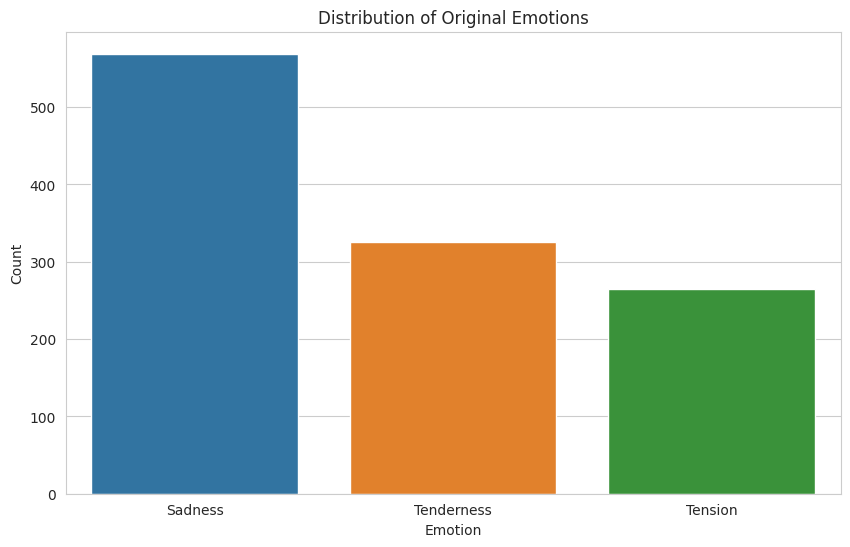

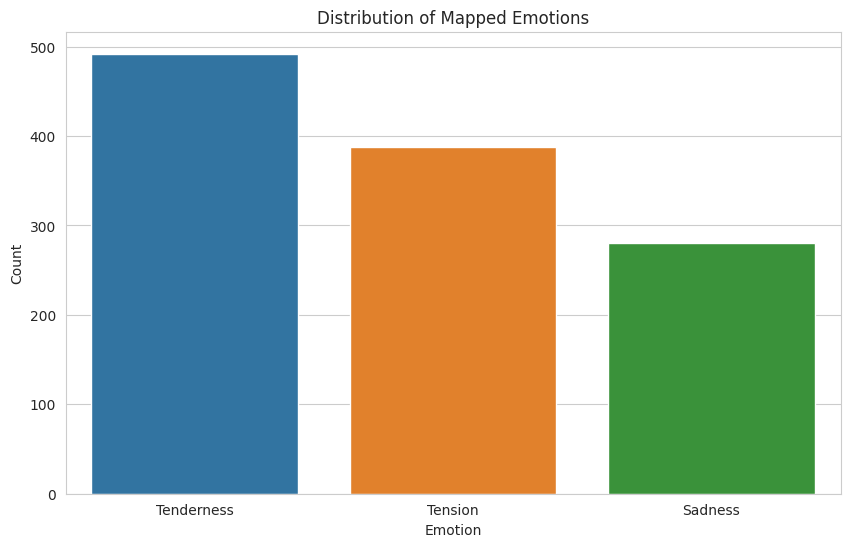

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set_style("whitegrid")

# Plot for original_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='label', order=s_data['label'].value_counts().index)
plt.title('Distribution of Original Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

# Plot for mapped_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='mapped_emotion', order=s_data['mapped_emotion'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

<ipython-input-58-5c15e2da70f4>:10: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)


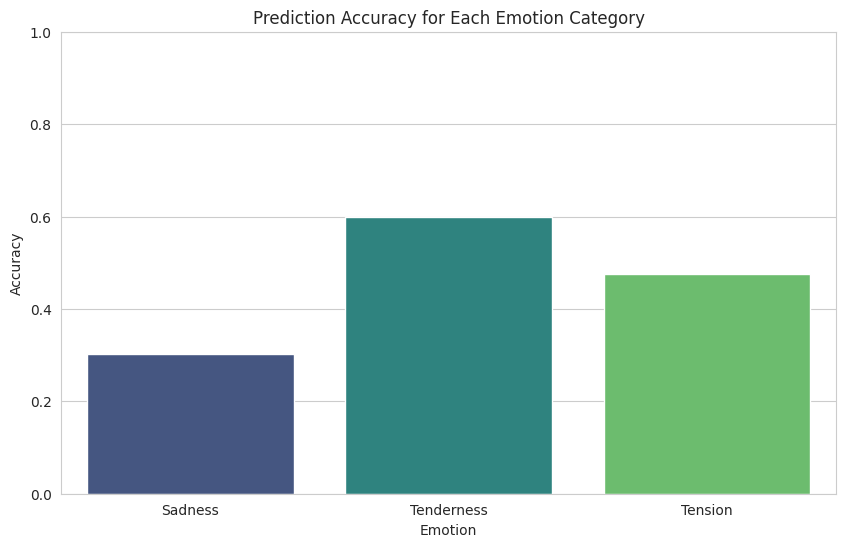

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(original_emotion, mapped_emotion, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies = cm.diagonal() / cm.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy = dict(zip(list(emotion_mapping.values()), accuracies))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy.keys()), y=list(emotion_accuracy.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy')
plt.xlabel('Emotion')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()

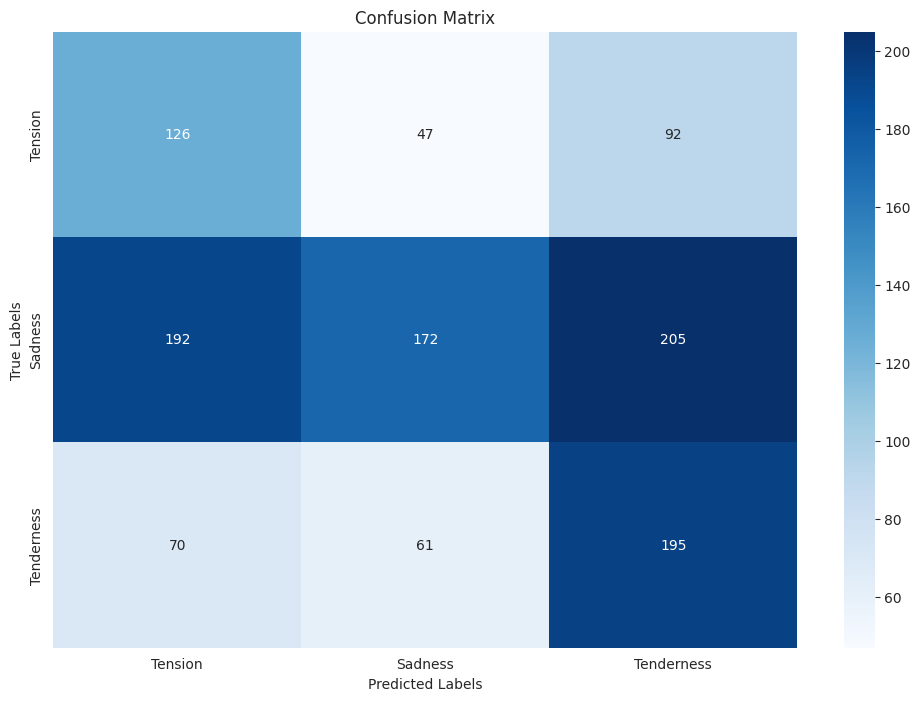

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels = list(set(original_emotion) | set(mapped_emotion))

# Calculate the confusion matrix
cm = confusion_matrix(original_emotion, mapped_emotion, labels=unique_labels)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
